In [ ]:
import xarray as xr
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from pathlib import Path
from utils.read_files import read_from_control, make_default_path
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

## Direct access to GRIDMET dataset

In [ ]:
gridmet_vars = {
    "tmax": "tmmx",
    "tmin": "tmmn",
    "spechum": "sph",
    "sw_down": "srad",
    "wind": "vs",
    "ppt": "pr"
}

# Store the name of the 'active' file in a variable
controlFile = 'control_EastRiver.txt'
# basin name and outlet gauge id
root_path = Path(read_from_control(controlFile, "root_path"))

def download_gridmet_forcing(location, variable):
    """
    Download the gridmet forcing data for the location and variable
    
    Parameters
    ----------
    location: str
        The location of the basin must be one of the following: EastRiver, TuolumneRiver
    variable: str
        The variable to download"""
    
    # set the output directory and check if file exists
    output_fn = root_path / f"domain_{location}/forcing/1_raw_data/gridmet_{variable}.nc"
    if os.path.exists(output_fn):
        print(f"File already exists: {output_fn}")
        return
    # Open the basin shapefile
    basin = gpd.read_file( root_path / f'domain_{location}/shapefiles/catchment/{location}.shp')

    # build URL from the GRIDMET server
    server = "http://thredds.northwestknowledge.net:8080"
    dataset = f"/thredds/dodsC/agg_met_{variable}_1979_CurrentYear_CONUS.nc"
    url = server + dataset

    # gather the url data
    ds = xr.open_dataset(url) 

    # rename day to time and lat to y and lon to x
    ds = ds.rename({'day': 'time', 'lat': 'y', 'lon': 'x'})

    # get the variable names 
    variable_names = list(ds.keys())
    # write the crs to the variable name
    ds = ds[variable_names[0]].rio.write_crs(basin.crs)

    # clip to the basin
    ds = ds.rio.clip_box(*basin.total_bounds)

    # save the dataset 
    ds.to_netcdf(output_fn)

    # close the dataset
    ds.close()
    return

In [5]:
# using a mixing of 0.6 * tmin + 0.4 * tmax, make a mean temperature dataset
def calculate_average_gridmet_temperature(tmmx, tmmn):
    """
    Calculate the average temperature from the max and min temperature
    
    Parameters
    ----------
    tmmx: xarray.DataArray
        The maximum temperature data
    tmnx: xarray.DataArray
        The minimum temperature data
    
    Returns
    -------
    xarray.DataArray
        The average temperature data
    """
    tavg_ds = 0.6 * tmmn['daily_minimum_temperature'] + 0.4 * tmmx['daily_maximum_temperature']
    # create a new xarray DataArray
    # tavg_ds = xr.DataArray(tavg, dims=["time", "y", "x"], coords={"time": tmmn.time, "y": tmmn.y, "x": tmmn.x})
    # name the new DataArray
    tavg_ds.name = "tavg"
    # add the attributes like units
    tavg_ds.attrs = {"units": "Kelvin",
                     "method": "Calculated from 0.6 * tmin + 0.4 * tmax"}
    return tavg_ds

In [6]:
# download the data
for location in ["EastRiver", "TuolumneRiver"]:
    for variable in gridmet_vars.values():
        download_gridmet_forcing(location, variable)


In [7]:
# download the data
for location in ["EastRiver", "TuolumneRiver"]:      
        # open the gridmet_tmmn.nc and gridmet_tmmx.nc files
        ds_tmmx = xr.open_dataset(f'/storage/dlhogan/summa_modeling_data/domain_{location}/forcing/1_raw_data/gridmet_tmmx.nc')
        ds_tmmn = xr.open_dataset(f'/storage/dlhogan/summa_modeling_data/domain_{location}/forcing/1_raw_data/gridmet_tmmn.nc')
        # calculate the average temperature
        ds_tavg = calculate_average_gridmet_temperature(ds_tmmx, ds_tmmn)
        # save the average temperature
        ds_tavg.to_netcdf(f'/storage/dlhogan/summa_modeling_data/domain_{location}/forcing/1_raw_data/gridmet_tavg.nc')

## Access using Climate Engine API

Temporal statistics include mean, median, max, min, total. Doesn't work too well for my purposes since I dont have Google cloud storage

In [8]:
# Function to load climate engine API credentials
def load_climateapi_credentials(credential_path):
    with open(credential_path, 'r') as f:
        credentials = json.load(f)
    return credentials
# Location of ARM credentials
credential_path = '/home/dlhogan/.climateapi_token.json'
credentials = load_climateapi_credentials(credential_path)
# api token for for climate engine
api_token = credentials.get('token')

In [10]:
# set root URL for API requests
root_url = 'https://api.climateengine.org/'
# authentication information
headers = {
    "Authorization": api_token
}
# storage location
storage = 'climateEngineAPI'

In [17]:
# select endpoint that exports a map of values 
valueEndpoint = "/raster/export/values"

# export filename
valueExport_filename = "gridmet_example"

# set the value parameters 
valueParams = {
    "dataset": "GRIDMET",
    "variable": gridmet_vars["ppt"],
    "temporal_statistic": "total",
    "start_date": "2023-01-01",
    "end_date": "2023-01-02",
    "bounding_box" : basin.total_bounds.tolist(),
    "export_path": f"{storage}/{valueExport_filename}"

}

In [18]:
requests.get(root_url + valueEndpoint, headers=headers, params=valueParams, verify=False)

<Response [500]>

In [15]:
valuesR = requests.get(root_url + valueEndpoint, headers=headers, params=valueParams, verify=False)
valuesExport_response = valuesR.json()
print(valuesExport_response)
print(valuesR.json)
print(valuesR.text)
print(valuesR.status_code)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## Access using Microsoft Planetary Computer
- *Note: this only accesses data from 1979-01-01 to 2020-12-31*

In [1]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

asset = catalog.get_collection("gridmet").assets["zarr-abfs"]
asset

<Asset href=abfs://gridmet/gridmet.zarr>

Installed `adlfs`, `ffspec`, `zarr`

In [12]:
ds = xr.open_zarr(
    asset.href,
    storage_options=asset.extra_fields["xarray:storage_options"],
    **asset.extra_fields["xarray:open_kwargs"]
)

In [24]:
# Example of possibilities
t_ds = ds['air_temperature'].rio.set_spatial_dims(x_dim='lon', y_dim='lat')
t_ds = t_ds.rio.write_crs("EPSG:4326")
example_ds = t_ds.rio.clip_box(*basin.total_bounds)

In [26]:
variables = ['air_temperature', 'precipitation_amount', 'specific_humidity', 'wind_speed']

<xarray.Dataset> Size: 597GB
Dimensions:                                    (time: 15341, lat: 585,
                                                lon: 1386, crs: 1)
Coordinates:
  * crs                                        (crs) uint16 2B 3
  * lat                                        (lat) float64 5kB 49.4 ... 25.07
  * lon                                        (lon) float64 11kB -124.8 ... ...
  * time                                       (time) datetime64[ns] 123kB 19...
Data variables:
    air_temperature                            (time, lat, lon) float32 50GB ...
    burning_index_g                            (time, lat, lon) float32 50GB ...
    dead_fuel_moisture_1000hr                  (time, lat, lon) float32 50GB ...
    dead_fuel_moisture_100hr                   (time, lat, lon) float32 50GB ...
    mean_vapor_pressure_deficit                (time, lat, lon) float32 50GB ...
    potential_evapotranspiration               (time, lat, lon) float32 50GB ...
    precipitation_amount                       (time, lat, lon) float32 50GB ...
    relative_humidity                          (time, lat, lon) float32 50GB ...
    specific_humidity                          (time, lat, lon) float32 50GB ...
    surface_downwelling_shortwave_flux_in_air  (time, lat, lon) float32 50GB ...
    wind_from_direction                        (time, lat, lon) float32 50GB ...
    wind_speed                                 (time, lat, lon) float32 50GB ...
Attributes: (12/19)
    Conventions:                CF-1.6
    author:                     John Abatzoglou - University of Idaho, jabatz...
    coordinate_system:          EPSG:4326
    date:                       02 July 2019
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_bounds_crs:      EPSG:4326
    ...                         ...
    geospatial_lon_units:       decimal_degrees east
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

<Axes: title={'center': 'crs = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

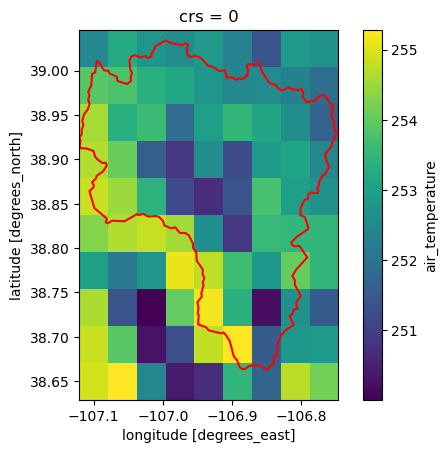

In [21]:

fig, ax = plt.subplots()
example_ds.isel(time=slice(0,10)).mean(dim='time').plot(ax=ax)
basin.boundary.plot(ax=ax, edgecolor='red')